# Surgical-classification 

steps:
- load the images
- train the model
- test model
- save model to a json format

> Use __tfjs__ env (only for me)

>**env:**
>1. install python 3.6.8 ``conda create -n ENVNAME python=3.6.8``
>2. ``pip install tensorflowjs``
>3. ``conda install notebook`` (conda manage dependencies more effectively than ``pip``)

In [1]:
import os 
import numpy as np 
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline

## Check if GPU is working 

In [341]:
import tensorflow as tf

# Clear the session
tf.keras.backend.clear_session()

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [342]:
try:
    """  shutil.rmtree("dataset/data-splited") """
    os.remove("save-model.h5")
    os.remove("model.h5")
except:
    print("OK")

In [343]:
import splitfolders
# Splits the dataset
""" splitfolders.ratio("dataset/data", output="dataset/data-splited", seed=0, ratio=(.7, .15, .15)) """

' splitfolders.ratio("dataset/data", output="dataset/data-splited", seed=0, ratio=(.7, .15, .15)) '

In [2]:
from keras.preprocessing.image import ImageDataGenerator

dir_path = "dataset/data-splited 3"


# Define data augmentation settings
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=False,
                                    vertical_flip=False,
                                    fill_mode="constant",
                                    cval=0, #  This will fill the new pixels with black
                                )

train_set = train_datagen.flow_from_directory(
                                            os.path.join(dir_path, "train"),
                                            shuffle=True,
                                            target_size=(224, 224),
                                            batch_size=16,
                                            class_mode="sparse",
                                            )

# Validation and test set
datagen = ImageDataGenerator(rescale=1./255)

val_set = datagen.flow_from_directory(
                                    os.path.join(dir_path, "val"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=16,
                                    class_mode="sparse",
                                    )

test_set = datagen.flow_from_directory(
                                    os.path.join(dir_path, "test"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=16,
                                    class_mode="sparse",
                                    )


Found 186 images belonging to 5 classes.
Found 15 images belonging to 5 classes.
Found 18 images belonging to 5 classes.


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model



# Define the model
inputs = Input(shape=(224, 224, 3))
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)  
x = Dense(32, activation='relu')(x)     
outputs = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  
              metrics=['acc'])

# Model summary
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 32)                2080

In [345]:
# Calculate the number of batches for trainset
total_samples = train_set.n
batch_size = train_set.batch_size
total_batches = (total_samples + batch_size - 1) // batch_size

print(f"Total samples: {total_samples}")
print(f"Batch size: {batch_size}")
print(f"Total batches: {total_batches}")

Total samples: 186
Batch size: 16
Total batches: 12


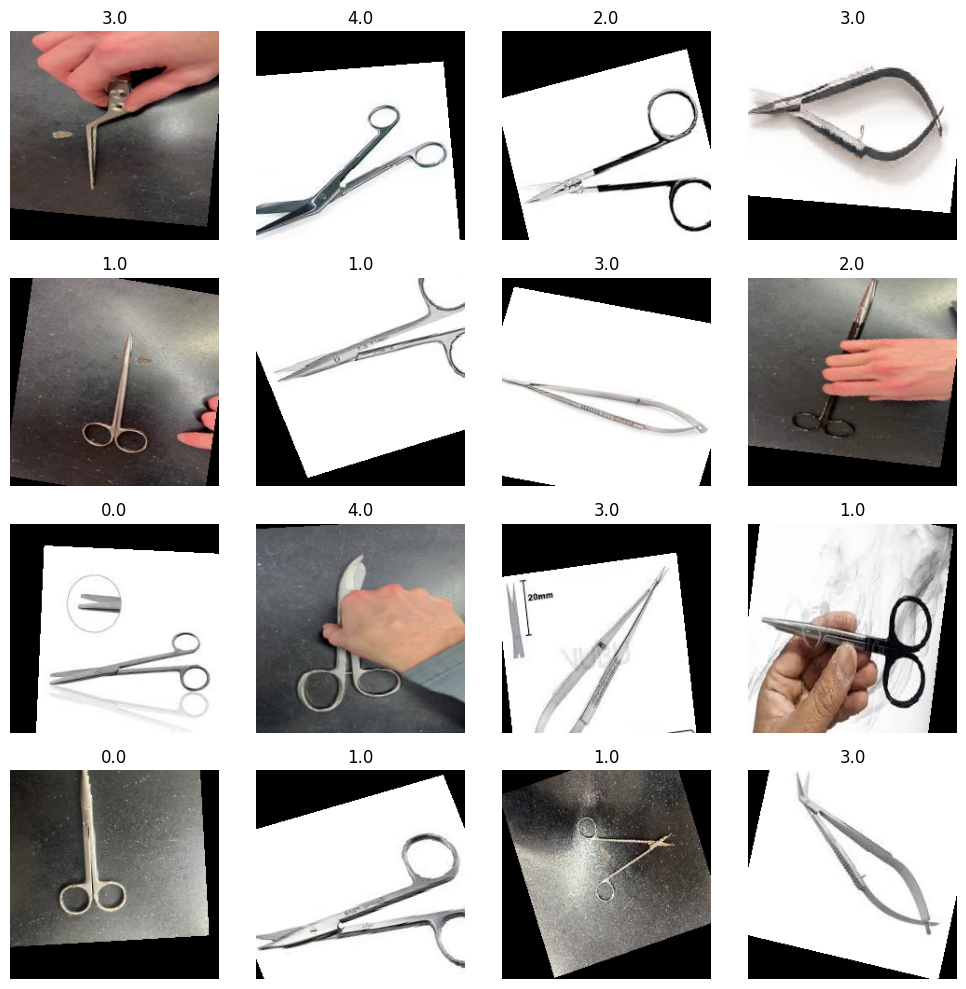

In [346]:
# Extract a batch of images and labels from train_set
images, labels = next(train_set)


# Plotting the first 25 images from the batch

img_train, label_train = next(train_set)

fig, axs =  plt.subplots(4,4, figsize=(10,10))

for i, ax in zip(range(16), axs.ravel()):
    ax.imshow(img_train[i])
    ax.axis('off')
    ax.set_title(label_train[i])
plt.tight_layout()
plt.show()

C:\Users\louis\AppData\Local\Temp\ipykernel_21868\826677915.py:11: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  proportion = pd.value_counts(name.classes, normalize=False, sort=False)


Mean proportion of images in train set: 37
Mean proportion of images in validation set: 3
Mean proportion of images in test set: 4


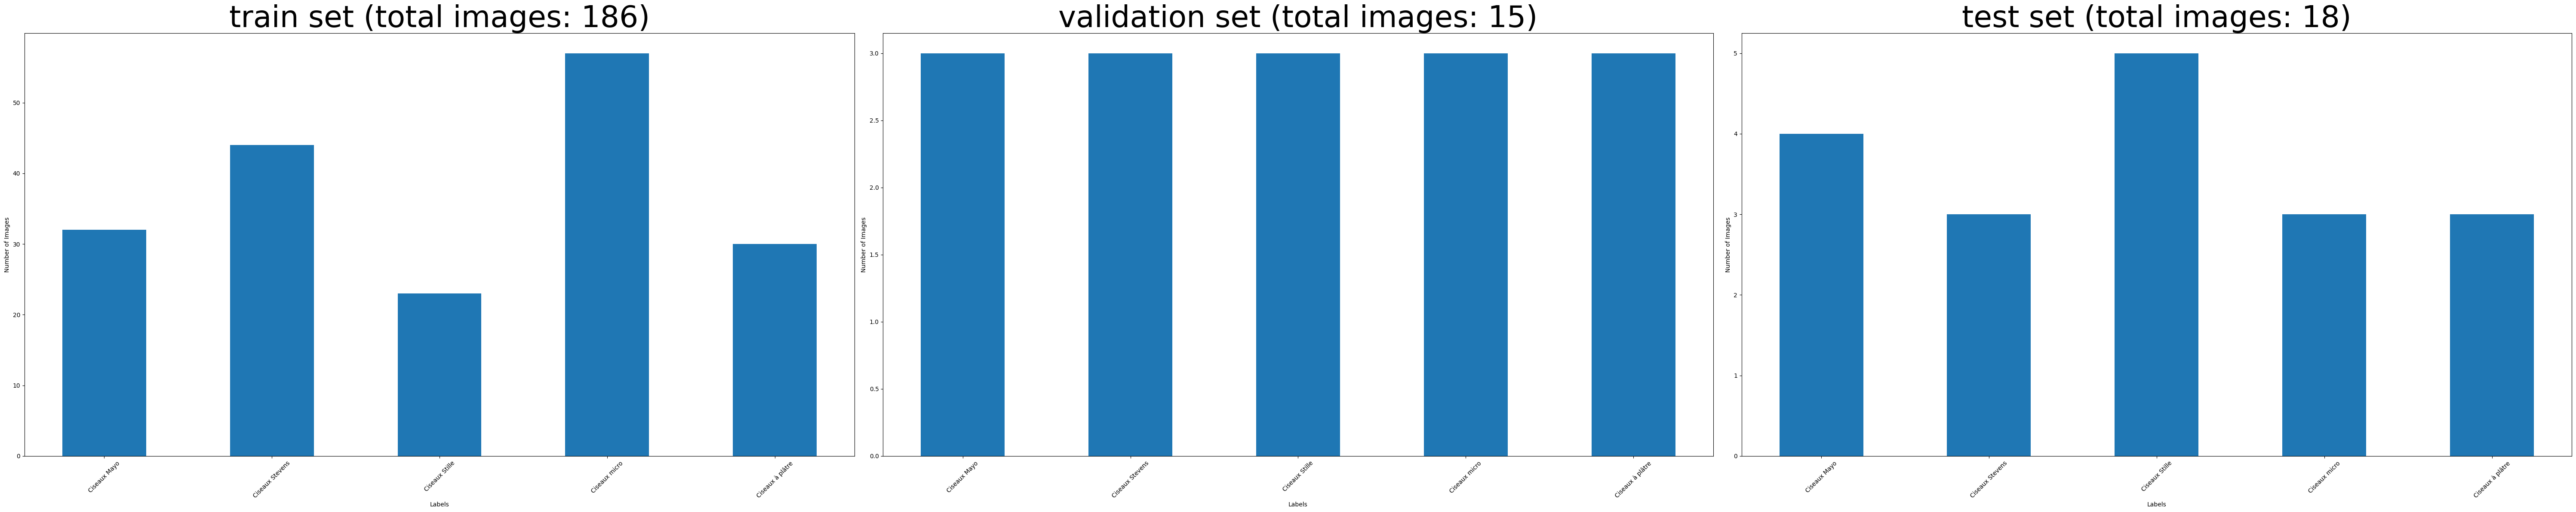

In [347]:
# Setup set names
set_names = ["train set", "validation set", "test set"]
categories = train_set.class_indices.keys()

# Plot
fig, axes = plt.subplots(1, 3, figsize=(60, 12))

for set_name, name, ax in zip(set_names, [train_set, val_set, test_set], axes.ravel()):

    # Get the count of each label in the train set
    proportion = pd.value_counts(name.classes, normalize=False, sort=False)
    print("Mean proportion of images in {}: {:.0f}".format(set_name, proportion.mean()))
    
    ax.bar(categories, proportion, width=0.5)
    ax.set_title(f"{set_name} (total images: {len(name.classes)})", fontsize=50)
    ax.set(
        xlabel="Labels",
        ylabel="Number of Images",
    )
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

> # Can't use MobileNetV3Large for tfjs 

In [348]:
import tensorflow.keras as keras
from tensorflow.keras.applications import MobileNetV3Large

""" np.random.seed(0)
tf.set_random_seed(0) """

# Load the pretrained model
base_model =  MobileNetV3Large(input_shape=(299, 299, 3), weights="imagenet", include_top=False, include_preprocessing=False)

# Make layers of the base model trainable
base_model.trainable = False

# Get the number of layers for the base_model
print(f"The base_model has {len(base_model.layers)} layers.")

# Unfreeze the last few layers for fine-tuning
""" fine_tune_at = 255 """

# Freezes the weights of the pre-train model
""" for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True """


# Creat a new classification layers on top
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
""" x = keras.layers.Dropout(0.2)(x) """
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(train_set.num_classes, activation="softmax")(x)

# Define the model
model = keras.Model(inputs=base_model.input, outputs=outputs)


# Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["acc"])

# Print network summary
model.summary()

The base_model has 262 layers.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 150, 150, 16  432         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 150, 150, 16  64         ['Conv[0][0]']                   
 tion)                          )                              

In [349]:
import tensorflow.keras as keras
from tensorflow.keras.applications import MobileNetV2
import random


np.random.seed(0)
random.seed(0)
tf.random.set_seed(0)

# Load the pretrained model
base_model =  MobileNetV2(input_shape=(224, 224, 3), weights="imagenet", include_top=False)

# Make layers of the base model trainable
base_model.trainable = False

# Get the number of layers for the base_model
print(f"The base_model has {len(base_model.layers)} layers.")

# Unfreeze the last few layers for fine-tuning
fine_tune_at = 250

# Freezes the weights of the pre-train model
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True


# Creat a new classification layers on top
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1024, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
outputs = keras.layers.Dense(train_set.num_classes, activation="softmax")(x)

# Define the model
model = keras.Model(inputs=base_model.input, outputs=outputs)


# Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["acc"])

# Print network summary
model.summary()

The base_model has 154 layers.
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                            

In [350]:
### Code to train the model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# End trainging whe accuracy stops improving
early_stopping = EarlyStopping(monitor="val_loss", patience=20)

# Reduce learning rate if val_loss doesn't improve
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1,
                              patience=3, min_lr=1e-10)

# Define model checkpoint
checkpoint = ModelCheckpoint("save-model.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

# Fit model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=200,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1,
    workers=1, # Number of workers Depend on your configuration
)

Epoch 1/200
12/12 [==============================] - ETA: 0s - loss: 1.5518 - acc: 0.3118
Epoch 1: val_loss improved from inf to 1.55811, saving model to save-model.h5
12/12 [==============================] - 11s 539ms/step - loss: 1.5518 - acc: 0.3118 - val_loss: 1.5581 - val_acc: 0.2667 - lr: 0.0010
Epoch 2/200
12/12 [==============================] - ETA: 0s - loss: 1.1500 - acc: 0.5000
Epoch 2: val_loss did not improve from 1.55811
12/12 [==============================] - 4s 337ms/step - loss: 1.1500 - acc: 0.5000 - val_loss: 1.7989 - val_acc: 0.4000 - lr: 0.0010
Epoch 3/200
12/12 [==============================] - ETA: 0s - loss: 1.0283 - acc: 0.5538
Epoch 3: val_loss improved from 1.55811 to 1.13892, saving model to save-model.h5
12/12 [==============================] - 4s 342ms/step - loss: 1.0283 - acc: 0.5538 - val_loss: 1.1389 - val_acc: 0.6000 - lr: 0.0010
Epoch 4/200
12/12 [==============================] - ETA: 0s - loss: 0.9055 - acc: 0.6290
Epoch 4: val_loss improved fro

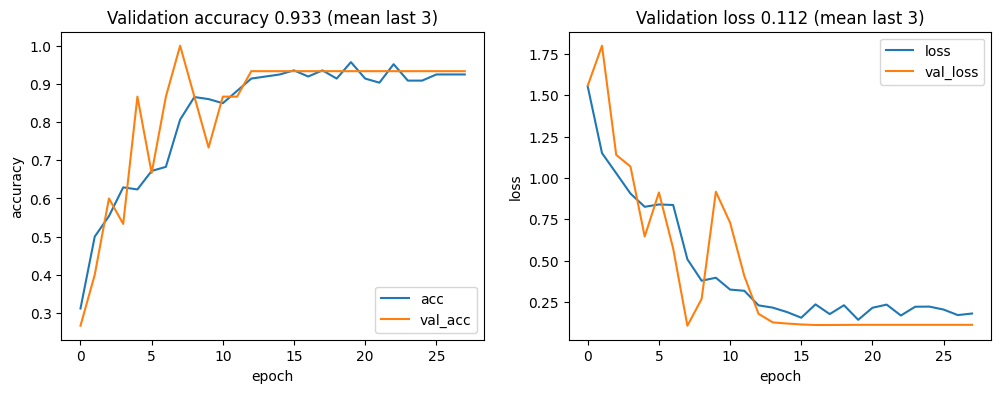

In [351]:
# Plots neural network performance metrics for train and validation
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Get the performance metrics
results = pd.DataFrame(history.history)

# Plot accuracy curves
results[["acc", "val_acc"]].plot(ax=ax1)
ax1.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(results["val_acc"][-3:]) # Last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")

# Plot loss curves
results[["loss", "val_loss"]].plot(ax=ax2)
ax2.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(results["val_loss"][-3:]) # Last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")

plt.show()

In [352]:
# Due to the use of a old version of python this code below will not work !

""" from sklearn.metrics import ConfusionMatrixDisplay

test_pred = model.predict(test_set)

# Compute the heigths probability for each entry
test_pred_labels = np.argmax(test_pred, axis=1)


# Plot Confusion Matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay.from_predictions(test_set.labels, test_pred_labels, ax=ax0)
ax0.set_title("Confusion Matrix values")

ConfusionMatrixDisplay.from_predictions(test_set.labels, test_pred_labels, normalize="true", ax=ax1)
ax1.set_title("Confusion Matrix percentage")
 
plt.show()"""

' from sklearn.metrics import ConfusionMatrixDisplay\n\ntest_pred = model.predict(test_set)\n\n# Compute the heigths probability for each entry\ntest_pred_labels = np.argmax(test_pred, axis=1)\n\n\n# Plot Confusion Matrix\nfig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))\n\nConfusionMatrixDisplay.from_predictions(test_set.labels, test_pred_labels, ax=ax0)\nax0.set_title("Confusion Matrix values")\n\nConfusionMatrixDisplay.from_predictions(test_set.labels, test_pred_labels, normalize="true", ax=ax1)\nax1.set_title("Confusion Matrix percentage")\n \nplt.show()'

2/2 [==============================] - 1s 90ms/step


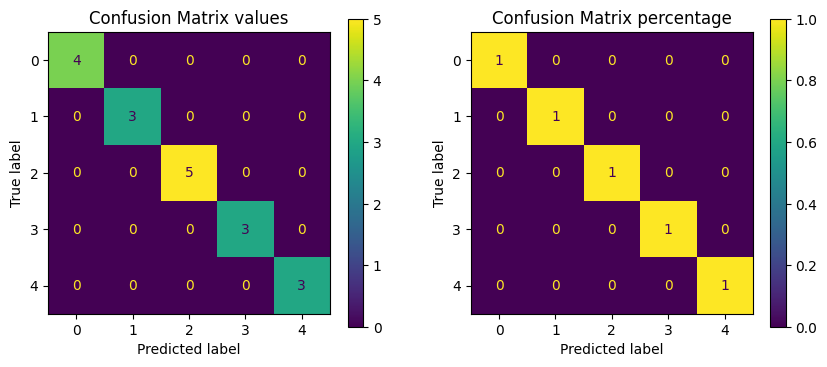

In [353]:
### Old vesion 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_pred = model.predict(test_set)

# Compute the heigths probability for each entry
test_pred_labels = np.argmax(test_pred, axis=1)

cm = confusion_matrix(test_set.labels, test_pred_labels)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

# Display Confusion Matrix
disp0 = ConfusionMatrixDisplay(confusion_matrix=cm)
disp0.plot(ax=ax0)
ax0.set_title("Confusion Matrix values")

# Display Normalized Confusion Matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp1.plot(ax=ax1)
ax1.set_title("Confusion Matrix percentage")

plt.show()


In [354]:
# Compute score on the test set
(test_loss, test_accuracy) = model.evaluate(test_set)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2%}".format(test_accuracy))

2/2 [==============================] - 0s 29ms/step - loss: 0.0053 - acc: 1.0000
Test loss: 0.01
Test accuracy: 100.00%


In [355]:
np.round(test_pred * 100)

array([[ 97.,   2.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [100.,   0.,   0.,   0.,   0.],
       [  0.,  99.,   0.,   0.,   0.],
       [  0., 100.,   0.,   0.,   0.],
       [  2.,  97.,   1.,   0.,   0.],
       [  0.,   0., 100.,   0.,   0.],
       [  0.,   0., 100.,   0.,   0.],
       [  0.,   0., 100.,   0.,   0.],
       [  0.,   0., 100.,   0.,   0.],
       [  0.,   0., 100.,   0.,   0.],
       [  2.,   0.,   0.,  98.,   0.],
       [  0.,   0.,   0., 100.,   0.],
       [  0.,   0.,   0., 100.,   0.],
       [  0.,   0.,   0.,   0., 100.],
       [  0.,   0.,   0.,   0., 100.],
       [  0.,   0.,   0.,   0., 100.]], dtype=float32)

In [356]:
model.save("model.h5")

In [359]:
test = datagen.flow_from_directory(
                                    os.path.join("dataset", "row-data-test"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=1,
                                    class_mode="sparse",
                                    )

Found 5 images belonging to 5 classes.


In [360]:
# Compute score on the test set
(loss, accuracy) = model.evaluate(test)

print("Test loss: {:.2f}".format(loss))
print("Test accuracy: {:.2%}".format(accuracy))

2/5 [===========>..................] - ETA: 0s - loss: 0.0451 - acc: 1.0000

5/5 [==============================] - 0s 88ms/step - loss: 0.0247 - acc: 1.0000
Test loss: 0.02
Test accuracy: 100.00%


In [361]:
classes = {num: name for name, num in test.class_indices.items()}
classes

{0: 'Ciseaux Mayo',
 1: 'Ciseaux Stevens',
 2: 'Ciseaux Stille',
 3: 'Ciseaux micro',
 4: 'Ciseaux à plâtre'}

In [362]:
predition = model.predict(test)
predition

5/5 [==============================] - 0s 87ms/step


array([[9.6938419e-01, 2.3041004e-02, 4.7587021e-03, 1.4098310e-04,
        2.6750588e-03],
       [4.6452545e-02, 9.4251859e-01, 9.7153448e-03, 3.6163002e-04,
        9.5185911e-04],
       [1.9261804e-03, 1.2326702e-03, 9.9654704e-01, 1.4223561e-04,
        1.5197757e-04],
       [7.4839321e-05, 1.2752451e-05, 3.4423209e-07, 9.9991202e-01,
        2.3661679e-09],
       [1.7262410e-02, 8.9857643e-03, 3.0324599e-03, 1.2209025e-04,
        9.7059727e-01]], dtype=float32)

In [363]:
np.round(predition * 100)

array([[ 97.,   2.,   0.,   0.,   0.],
       [  5.,  94.,   1.,   0.,   0.],
       [  0.,   0., 100.,   0.,   0.],
       [  0.,   0.,   0., 100.,   0.],
       [  2.,   1.,   0.,   0.,  97.]], dtype=float32)

In [364]:
for i in predition.argmax(axis=1):
    print(f"Image {i +1} is: {classes.get(i)}")

Image 1 is: Ciseaux Mayo
Image 2 is: Ciseaux Stevens
Image 3 is: Ciseaux Stille
Image 4 is: Ciseaux micro
Image 5 is: Ciseaux à plâtre


## Save the model to json using tensorflowjs

cmd command: ``tensorflowjs_converter --input_format=keras  model.h5 tfjs_model``

In [366]:
{num: name for name, num in train_set.class_indices.items()}

{0: 'Ciseaux Mayo',
 1: 'Ciseaux Stevens',
 2: 'Ciseaux Stille',
 3: 'Ciseaux micro',
 4: 'Ciseaux à plâtre'}